# Why Does Cosine Annealing With Warmup Stabilize Training?

[![Twitter Handle](https://img.shields.io/badge/Twitter-@gaohongnan-blue?style=social&logo=twitter)](https://twitter.com/gaohongnan)
[![LinkedIn Profile](https://img.shields.io/badge/@gaohongnan-blue?style=social&logo=linkedin)](https://linkedin.com/in/gao-hongnan)
[![GitHub Profile](https://img.shields.io/badge/GitHub-gao--hongnan-lightgrey?style=social&logo=github)](https://github.com/gao-hongnan)
![Tag](https://img.shields.io/badge/Tag-Brain_Dump-red)
![Tag](https://img.shields.io/badge/Level-Beginner-green)
[![Code](https://img.shields.io/badge/View-Code-blue?style=flat-square&logo=github)](https://github.com/gao-hongnan/omniverse/blob/main/omnivault/schedulers/cosine_annealing_warmup.py)

```{contents}
:local:
```

In [1]:
%config InlineBackend.figure_format = 'svg'

from __future__ import annotations

import sys
from pathlib import Path

from IPython.display import display

def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
else:
    raise ImportError("Root directory not found.")

use_svg_display()

## Motivation

In training deep neural networks, learning rate is definitely one of the most
important parameter to tune. Optimization algorithms like
[Adam](https://arxiv.org/abs/1412.6980) and
[SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) tell us how the
weights $\boldsymbol{\theta} \in \boldsymbol{\Theta}$ should be updated, but the
learning rate $\eta$ tells us the **_rate_** at which the weights are being
updated.

Theoretically and empircally, the **_magnitude_** of the learning rate $\eta$
can have a significant impact on the training process. If the learning rate is
too _large_, we might experience
[divergence](<https://en.wikipedia.org/wiki/Divergence_(mathematics)>), on the
other hand, if the learning rate is too _small_, the model might take longer to
converge or might get stuck in a local
[minima](https://en.wikipedia.org/wiki/Maxima_and_minima). The condition number
of the problem also impacts optimization efficiency, as discussed in
[the momentum section](https://d2l.ai/chapter_optimization/momentum.html#sec-momentum),
where the concept can be understood as the ratio between the smallest and
largest changes possible in response to adjustments in different directions of
the parameter space, reflecting the variance in sensitivity across these
directions[^1] {cite}`zhang2023dive`. As we progress through the training steps,
it is also equally important to apply a learning rate scheduler to adjust (may
_not_ be monotonous decay) the learning rate _discriminatively_.

In the paper
[_SGDR: Stochastic Gradient Descent with Restarts_](https://arxiv.org/abs/1608.03983)
by Loshchilov and Hutter, they introduced an heuristic that relies on the
empirical observation that we can improve the convergence of the model (usually
in ill-conditioned situations) if we want follow an **_annealing_** process over
the learning rate. This means that at the beginning of training, we do not want
to decrease the learning too drastically. My (potentially wrong) intuition is
that this may allow the model to consider exploring a larger parameter space
without too much constraints than if we were to rapidly decrease the learning
rate. The authors further claim that as we progress towards the end of the
training, we would want to "fine-tune" the model parameters with a very small
learning rate, as it could potentially help "refine" the solution space to find
a "more optimal" set of parameters {cite}`DBLP:journals/corr/LoshchilovH16a`.
This idea _naturally lands_ us to using _cosine function_ because the cosine
curve starts with a _gentle slope_, which coincides with the idea of _gradual
decrease_ in learning rate in the beginning, and the cosine curve naturally
flattens and approaches zero towards the end as it reaches the end of its cycle,
which again coincides with the idea of _fine-tuning_ the model parameters with a
very small learning rate.

Consequently, a cosine decaying scheduler has the below function form for
learning rates in the range $t \in [0, T]$:

$$
\eta_t=\eta_T+\frac{\eta_0-\eta_T}{2}\left(1+\cos \left(\frac{\pi t}{T}\right)\right)
$$

Here $\eta_0$ is the initial learning rate, $\eta_T$ is the target rate at time
$T$. Furthermore, for $t>T$ we simply pin the value to $\eta_T$ without
increasing it again. $T$ represents the end of the learning rate annealing phase
rather than the absolute end of training. It's the point in time when the
learning rate reaches $\eta_T$, the target rate, and beyond which the learning
rate is maintained constant at $\eta_T$.

-   During $0 \leq t < T$: The learning rate $\eta_t$ is actively adjusted
    according to the cosine annealing formula. It transitions from the initial
    learning rate $\eta_0$ towards the target rate $\eta_T$, following a
    half-cosine wave.
-   For $t \geq T$: The learning rate is set to $\eta_T$ and no longer changes.
    This doesn't necessarily mean that training must stop at $t = T$. Training
    can continue beyond $T$ with the learning rate fixed at $\eta_T$.

In code, we can observe the behavior of the cosine annealing scheduler as
follows:

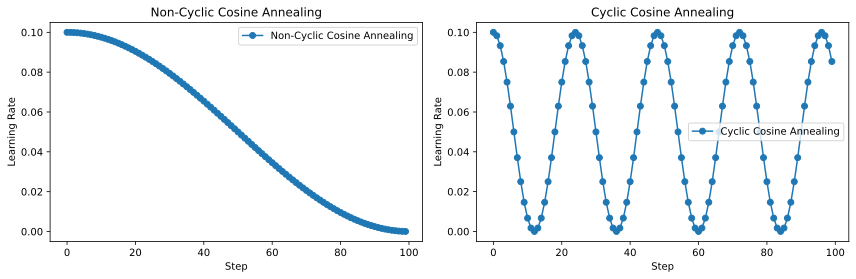

In [2]:
from __future__ import annotations

from typing import Any, List

import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR, _LRScheduler

def get_learning_rates(optimizer: Optimizer, scheduler: _LRScheduler, steps: int) -> List[float]:
    lrs = []
    for _ in range(steps):
        lrs.append(optimizer.param_groups[0]["lr"])
        optimizer.step()
        scheduler.step()
    return lrs

def plot_learning_rates(
    lrs: List[float], title: str, marker: str = "o", ax: plt.Axes | None = None, **kwargs: Any
) -> None:
    ax = ax or plt.gca()

    ax.plot(lrs, label=title, marker=marker, **kwargs)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Learning Rate")
    ax.legend()

def main() -> None:
    initial_lr = 0.1
    eta_min = 0
    steps = 100
    model = torch.nn.Linear(2, 1)

    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
    scheduler_non_cyclic = CosineAnnealingLR(optimizer, T_max=steps, eta_min=eta_min)
    lrs_non_cyclic = get_learning_rates(optimizer, scheduler_non_cyclic, steps)

    optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr)
    scheduler_cyclic = CosineAnnealingLR(optimizer, T_max=steps // 8, eta_min=eta_min)
    lrs_cyclic = get_learning_rates(optimizer, scheduler_cyclic, steps)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_learning_rates(lrs_non_cyclic, 'Non-Cyclic Cosine Annealing', ax=axes[0])
    plot_learning_rates(lrs_cyclic, 'Cyclic Cosine Annealing', ax=axes[1])

    plt.tight_layout()
    plt.show()

main()

## Warmup

Our motivation would have ended here, but in practice, we often see that the
cosine annealing scheduler is often combined with a warmup phase. In
{numref}`why-cosine-warmup-loss-plot`, we can see that the loss curve is
relatively smooth and converges way better than the ones without warmup.

```{figure} ../assets/warmup_loss_plot_uvadlc.svg
---
name: why-cosine-warmup-loss-plot
---

Training loss v.s. # of iterations of Transformers on the De-En IWSLT’14 dataset.

**Image Credit:**
[ON THE VARIANCE OF THE ADAPTIVE LEARNING RATE AND BEYOND](https://arxiv.org/pdf/1908.03265.pdf)
```

It might be worth having some intuition on why warmup works so well in practice,
and in particular, in language models like
[Transformers](https://arxiv.org/abs/1706.03762).

Firstly, the [RAdam](https://arxiv.org/pdf/1908.03265.pdf) paper suggests warmup
works as a variance reduction technique, which overcomes the problem of
[bias correction factors](https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for)
in optimizers like Adam, where having these bias correction factors would lead
to larger variance in the adaptive learning rate during the **initial** training
iterations {cite}`lippe2023uvadlc`. More concretely, Adam estimates the first
and second moments of the gradient to change the learning rate of each
individual parameter (hence adaptive) and having high variance between adaptive
learning rates may de-stablize the training. If we don't want to swap out Adam,
then this calls for a warmup phase to stabilize the learning rate and reduce the
variance in the early stages of training.

Secondly, language models like Transformers use iteratively applied Layer
Normalization across layers can lead to very high gradients during the first
iterations, which can be solved by using
[Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf)
(similar to Pre-Activation ResNet), which applies normalization before the
layer's main operations, contributing to gradient stabilization and reducing the
necessity for a warm-up phase, or replacing Layer Normalization by other
techniques
([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf),
[Power Normalization](https://arxiv.org/abs/2003.07845))
{cite}`lippe2023uvadlc`.

However, even though there are solutions to the problem, certain setups still
use the Adam optimizer, and therefore warmup is still a simple and effective
technique to stabilize the learning rate in the early stages of training -
solving the afforementioned problems (i.e. stabilize the bias correction
factors, moving averages of gradients and squared gradients).

To this end, we end our discussion on the motivation behind 1) using cosine
annealing schedulers and 2) using warmup phases, often coupled with cosine
annealing schedulers. In what follows, we will provide a more formal definition
of the cosine annealing scheduler with warmup, and provide a running example to
illustrate the behavior of the scheduler.

## Definition

The `CosineAnnealingWithWarmupScheduler` decays the learning rate $\eta$
according to the decreasing part of a cosine curve, with an initial warmup
$t_{\text{warmup}}$.

This scheduler modulates $\eta$ within defined upper and lower bounds over a
predetermined interval, employing a cosine function. The formula for cosine
annealing reflects the shape of a half-cosine wave, which decreases from a
maximum value to a minimum and then increases back to the maximum. This cycle
can repeat multiple times over the training process, depending on how the
scheduler is configured. Although this approach suggests cyclic adjustments
(oscillations) within the training duration, for simplicity's sake, our specific
implementation, inspired by
[**MosaicML's Composer's CosineAnnealingWithWarmupScheduler**](https://docs.mosaicml.com/projects/composer/en/latest/api_reference/generated/composer.optim.CosineAnnealingWithWarmupScheduler.html),
explicitly excludes considerations for such cycles/oscillations.

```{prf:definition} Cosine Annealing With Warmup
:label: why-do-we-use-warmup-cosine-scheduler-definition

The `CosineAnnealingWithWarmupScheduler` modulates the **learning rate** $\eta$
according to a **two-phase** process: a **_warmup_** phase followed by a
**cosine annealing** phase. The learning rate _multiplier_[^lr-multiplier]
$\alpha_{t}$ at any given time (step) $t$ is given by:

$$
\begin{equation}
\alpha_{t} = \begin{cases}
    \frac{t}{t_{\text{warmup}}}, & \text{if } t < t_{\text{warmup}} \\
    \alpha_f + (1 - \alpha_f) \times \frac{1}{2} \left[1 + \cos(\pi \times \tau_w) \right], & \text{otherwise}
\end{cases}
\end{equation}
$$

where we denote:

-   $t$ represents the **current** training step or epoch.
-   $\eta_{\max}$ as the **maximum** learning rate reached during training, and
    often is the **initial** learning rate given into an optimizer.
-   $t_{\text{warmup}}$ denotes the duration of the warmup period, in terms of
    the number of steps or epochs, during which the learning rate **linearly**
    increases to the maximum learning rate $\eta_{\max}$.
-   $t_{\max}$ as the **maximum** number of training steps, or maximum number of
    iterations in an epoch (see
    [here](https://github.com/skorch-dev/skorch/issues/610)).
-   $\tau_w = \frac{t - t_{\text{warmup}}}{t_{\max}}$, the fraction of
    post-warmup time elapsed,
-   $\alpha_f$ is a _scaling_ factor that determines the **final** learning rate
    multiplier to decay to (a value between $0$ and $1$), and this is a _fixed_
    value. For example, if $\alpha_f = 0.1$ and the initial learning rate is
    $\eta_{\max} = 3e-4$, then the final learning rate will be
    $\eta_{\min} = 3e-4 \times 0.1 = 3e-5$.

The actual learning rate $\eta_{t}$ at time (step) $t$ is then computed as:

$$
\begin{equation}
    \eta_{t} = \alpha_{t} \times \eta_{\max}
\end{equation}
$$

where we emphasize again that $\eta_{\max}$ is the **maximum** learning rate
reached during training.
```

```{admonition} A Word on Oscillations
:class: note

Note that if you set $t_{\max}$ to the total number of training steps that is
needed for the entire dataset $\mathcal{S}$, the scheduler _will only decay_ the
learning rate after the warmup phase and not oscillate further. This
configuration means that after completing the linear increase during the warmup,
the learning rate will decrease following a cosine curve until it reaches the
final learning rate determined by $\alpha_f$.

-   **Single Cycle (No Oscillation)**: If $t_{\max}$ is set to cover exactly one
    half-cycle of the cosine function from the end of the warmup phase to the
    conclusion of training, the learning rate will monotonically decrease from
    its maximum value (at the end of warmup) to its minimum value (as determined
    by $\alpha_f$) without oscillating. This is because the scheduler's active
    period only spans a single descent phase of the cosine wave.
-   **Multiple Cycles (Oscillation)**: If $t_{\max}$ is set to allow for a
    longer duration than what is needed for a single half-cycle descent, the
    cosine annealing function can complete its initial descent and then begin to
    ascend as part of a new cycle. This leads to oscillations in the learning
    rate—after decreasing, it will start to increase again, potentially multiple
    times, depending on the total number of cycles fitted within $t_{\max}$.
    This is where the term "oscillation" comes into play; it describes the
    periodic increase and decrease in the learning rate according to the cosine
    function over multiple cycles.

True oscillation, where the learning rate decreases and then increases within a
training regime, typically requires either a restart mechanism (as seen in
[Cosine Annealing with Warm Restarts](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html))
or an explicit multi-cycle configuration. A standard cosine annealing scheduler,
especially with a warmup phase, generally only supports a monotonic decrease
within a single cycle, unless it is specifically designed to handle restarts or
multiple cycles.
```

## Implementation

In [3]:
from __future__ import annotations

import math
from functools import partial

from torch.optim.lr_scheduler import LambdaLR
from torch.optim.optimizer import Optimizer
from torch.optim import Adam
from torch import nn

def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, alpha_f: float
) -> float:
    if current_step < num_warmup_steps:
        alpha = current_step / max(1, num_warmup_steps)
    else:
        tau_w = (current_step - num_warmup_steps) / num_training_steps
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


def get_cosine_annealing_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    alpha_f: float = 0.1,
    last_epoch: int = -1,
    verbose: bool = False,
) -> LambdaLR:
    lr_lambda = partial(
        _get_cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        alpha_f=alpha_f,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch, verbose)

# Experiment 1
num_warmup_steps = 5
num_training_steps = 10
alpha_f = 0.5
initial_lr = 3e-4

dummy_model = nn.Linear(1, 1)
optimizer = Adam(dummy_model.parameters(), lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, num_warmup_steps, num_training_steps, alpha_f)
assert isinstance(scheduler, LambdaLR)
lrs1 = get_learning_rates(optimizer, scheduler, steps=num_training_steps)

# Experiment 2
num_warmup_steps = 200
num_training_steps = 1000

dummy_model = nn.Linear(1, 1)
optimizer = Adam(dummy_model.parameters(), lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, num_warmup_steps, num_training_steps, alpha_f)
lrs2 = get_learning_rates(optimizer, scheduler, steps=num_training_steps)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_learning_rates(lrs1, 'Cosine Annealing With Warmup (Short)', ax=axes[0])
plot_learning_rates(lrs2, 'Cosine Annealing With Warmup (Long)', ax=axes[1])

TypeError: LambdaLR.__init__() takes from 3 to 4 positional arguments but 5 were given

## An Example Walkthrough

For simplicity, we assume that there are a total of $10$ training steps (or
epoches) depending on how you define it. We will use the following
hyperparameters:

-   $\eta_{\max} = 3 \times 10^{-4}$
-   $t_{\text{warmup}} = 5$
-   $t_{\max} = 10$
-   $\alpha_f = 0.5$

We can use the code to verify the learning rate at each step with our manual
computation.

In [ ]:
from rich.pretty import pprint
pprint(lrs1)

### 1. Warmup Phase

During the warmup phase, when the **current** training step $t$ is less than the
warmup time $t_{\text{warmup}}$, the learning rate multiplier is **linearly**
increased from $0$ to $1$.

Mathematically, the learning rate multiplier $\alpha_{t}$ at time (step) $t$ is

$$
\alpha_{t} = \frac{t}{t_{\text{warmup}}}
$$

The learning rate at this phase is:

$$
\begin{align*}
\eta_{t} &=  \alpha_{t} \times \eta_{\max} \\
&= \frac{t}{t_{\text{warmup}}} \times \eta_{\max}
\end{align*}
$$

During the warmup phase, the learning rate will linearly increase from $0$ to
$\eta_{\max}$ in the first $t_{\text{warmup}}$ steps. Since
$\eta_{\max} = 3 \times 10^{-4}$ and $t_{\text{warmup}} = 5$, the learning rate
will be increased as follows:

-   $t = 1$:

    $$
    \begin{align*}
    \alpha_1 &= \frac{t}{t_{\text{warmup}}} = \frac{1}{5} = 0.2 \\
    \eta_1 &= \alpha_1 \times \eta_{\max} = 0.2 \times 3 \times 10^{-4} = 6 \times 10^{-5}
    \end{align*}
    $$

-   $t = 2$:

    $$
    \begin{align*}
    \alpha_2 &= \frac{t}{t_{\text{warmup}}} = \frac{2}{5} = 0.4 \\
    \eta_2 &= \alpha_2 \times \eta_{\max} = 0.4 \times 3 \times 10^{-4} = 1.2 \times 10^{-4}
    \end{align*}
    $$

-   $t = 3$:

    $$
    \begin{align*}
    \alpha_3 &= \frac{t}{t_{\text{warmup}}} = \frac{3}{5} = 0.6 \\
    \eta_3 &= \alpha_3 \times \eta_{\max} = 0.6 \times 3 \times 10^{-4} = 1.8 \times 10^{-4}
    \end{align*}
    $$

-   $t = 4$:

    $$
    \begin{align*}
    \alpha_4 &= \frac{t}{t_{\text{warmup}}} = \frac{4}{5} = 0.8 \\
    \eta_4 &= \alpha_4 \times \eta_{\max} = 0.8 \times 3 \times 10^{-4} = 2.4 \times 10^{-4}
    \end{align*}
    $$

-   $t = 5$:

    $$
    \begin{align*}
    \alpha_5 &= \frac{t}{t_{\text{warmup}}} = \frac{5}{5} = 1 \\
    \eta_5 &= \alpha_5 \times \eta_{\max} = 3 \times 10^{-4} \times 1 = 3 \times 10^{-4}
    \end{align*}
    $$

The linear relationship for the warmup phase can be represented as a function of
the current training step $x$:

$$
f(t) = \frac{t}{t_{\text{warmup}}}
$$

where $t_{\text{warmup}}$is the total number of steps in the warmup phase. This
function describes how the learning rate multiplier $\alpha_t$ grows linearly
from $0$ to $1$ as $t$ progresses from $0$ to $t_{\text{warmup}}$.

### 2. Cosine Decay Phase

After the warmup phase, the learning rate multiplier follows a cosine decay
pattern. This phase commences once the current training step $t$ is greater than
or equal to the warmup time $t_{\text{warmup}}$, and it continues until the
maximum training step $t_{\text{max}}$.

#### 2.1. Tau Fraction

We first define a variable $\tau_w$ to represent the fraction of post-warmup
time elapsed. Mathematically, it is defined as:

$$
\tau_w = \frac{t - t_{\text{warmup}}}{t_{\text{max}}}
$$

where:

-   $t$: Current training step.
-   $t_{\text{warmup}}$: Warmup time in training steps.
-   $t_{\text{max}}$: Total duration of the scheduler in training steps.

#### 2.2. Learning Rate Multiplier

The learning rate multiplier $\alpha_t$ during the cosine decay phase is given
by:

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)  \left(1 + \cos \left(\pi \times \tau_w\right)\right)
$$

where $\alpha_f$ is the scaling factor that determines the final learning rate
multiplier to decay to.

#### 2.3. Learning Rate

The actual learning rate $\eta_t$ during this phase is then computed as:

$$
\eta_{t} = \alpha_{t} \times \eta_{\text{max}}
$$

#### Example

Using the running example with:

-   $\eta_{\text{max}} = 3 \times 10^{-4}$
-   $t_{\text{warmup}} = 5$
-   $t_{\text{max}} = 10$
-   $\alpha_f = 0.5$

The learning rate will be computed as follows:

-   $t = 6$:

    $$
    \begin{align*}
    \tau_w &= \frac{6 - 5}{10} = 0.1 \\
    \alpha_6 &= 0.5 + \frac{1}{2}(1 - 0.5) \left(1 + \cos \left(0.1\pi\right)\right) = 0.975445 \\
    \eta_6 &= 3 \times 10^{-4} \times 0.975445 = 0.0002963292387221365
    \end{align*}
    $$

-   $t = 7$:

    $$
    \begin{align*}
    \tau_w &= \frac{7 - 5}{10} = 0.2 \\
    \alpha_7 &= 0.5 + \frac{1}{2}(1 - 0.5) \left(1 + \cos \left(0.2\pi\right)\right) = 0.904508 \\
    \eta_7 &= 3 \times 10^{-4} \times 0.904508 = 0.00028567627457812104
    \end{align*}
    $$

-   ... (and so on for the remaining steps)

#### Mathematical Intuition

This version of implementation is slightly confusing because there is an
$\alpha_f$ term in the cosine decay formula.

1. **Cosine Function**: The cosine function oscillates between -1 and 1. By
   taking a scaled and shifted version of the cosine function, we can create a
   curve that starts at its highest point and gradually descends to its lowest
   point over the interval $[0, t_{\text{max}}]$.

2. **Decay Formula**: The formula for the learning rate multiplier during the
   decay phase is:

    $$
    \alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\pi \times \tau_w\right)\right)
    $$

    Here, $\tau_w$ is the fraction of time elapsed since the warmup phase, and
    it ranges from 0 to 1. The $\cos(\pi \times \tau_w)$ term creates a curve
    that starts at 1 (when $\tau_w = 0$) and ends at -1 (when $\tau_w = 1$). The
    scaling and shifting ensure that $\alpha_t$ starts at 1 and decays to
    $\alpha_f$.

More concretely, the expression

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\pi \times \tau_w\right)\right)
$$

describes the learning rate multiplier during the decay phase, where $\tau_w$ is
the fraction of time elapsed since the warmup phase where $\tau_w$ is the
fraction of time elapsed since the warmup phase, and it ranges from $0$ to $1$.

Let's zoom into the cosine decay part in more details:

-   The term $\cos(\pi \times \tau_w)$ oscillates between $1$ and $-1$ as
    $\tau_w$ varies from $0$ to $1$.
-   When you add $1$ to this term, the expression $1 + \cos(\pi \times \tau_w)$
    oscillates between $0$ and $2$.
-   Multiplying this by $\frac{1}{2}$ scales it down, so the expression
    $\frac{1}{2}\left(1 + \cos(\pi \times \tau_w)\right)$ oscillates between 0
    and 1.
-   The term $\frac{1}{2}(1 - \alpha_f)$ scales this oscillation so that the
    amplitude is adjusted based on the desired final learning rate multiplier
    $\alpha_f$. This means if $\alpha_f = 0.5$, the expression
    $\frac{1}{2}(1 - \alpha_f)\left(1 + \cos(\pi \times \tau_w)\right)$
    oscillates between $0$ and $0.5$.
-   Adding $\alpha_f$ shifts the entire expression so that it starts at 1 when
    $\tau_w = 0$ and decays to $\alpha_f$ when $\tau_w = 1$.

The addition of $\alpha_f$ in the decay formula serves the purpose of setting
the final value of the learning rate multiplier $\alpha_t$ to $\alpha_f$ at the
end of training. Let's break down the equation step by step to understand why
$\alpha_f$ is added back.

Given the formula:

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\pi \times \tau_w\right)\right)
$$

First, consider the case where $\tau_w = 0$ (i.e., the beginning of the decay
phase):

-   The cosine term becomes $\cos(0) = 1$.
-   The entire expression inside the parentheses becomes $1 + 1 = 2$.
-   The scaling factor $\frac{1}{2}(1 - \alpha_f)$ then multiplies this by
    $\frac{1 - \alpha_f}{2}$.
-   So the expression becomes
    $\alpha_f + \frac{1 - \alpha_f}{2} \times 2 = \alpha_f + (1 - \alpha_f) = 1$.

So at $\tau_w = 0$, $\alpha_t$ starts at 1.

Now consider the case where $\tau_w = 1$ (i.e., the end of training):

-   The cosine term becomes $\cos(\pi) = -1$.
-   The entire expression inside the parentheses becomes $1 - 1 = 0$.
-   The scaling factor then multiplies this by
    $\frac{1 - \alpha_f}{2} \times 0 = 0$.
-   So the expression becomes $\alpha_f + 0 = \alpha_f$.

So at $\tau_w = 1$, $\alpha_t$ decays to $\alpha_f$.

By adding $\alpha_f$, we ensure that the learning rate multiplier starts at $1$
and smoothly decays to the desired final value $\alpha_f$. Without adding
$\alpha_f$, the expression would start at $1$ but decay to $0$, rather than the
intended final value. The addition of $\alpha_f$ shifts the entire decay curve
so that it aligns with the desired starting and ending values.

## PyTorch's CosineAnnealingLR vs. Composer's CosineAnnealingScheduler

We know that Composers' `CosineAnnealingWithWarmupScheduler` is basically its
`CosineAnnealingScheduler` with warmup, and the latter is also basically a copy
of PyTorch's `CosineAnnealingLR`. However, there is a slight difference in their
formulas. Let's compare the two to see if they are equivalent.

In PyTorch's
[CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR),
they implemented the cosine annealing scheduler without warmup, but the base
formula should be similar. Let's take a look to see how they coincide.

1. [PyTorch’s `CosineAnnealingLR` without warmup](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR)
2. [Composers `CosineAnnealingScheduler` without warmup](https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.optim.CosineAnnealingScheduler.html#composer.optim.CosineAnnealingScheduler)

The formula looks a bit different at first glance (without loss of generality,
we can ignore warmup here), after digging a bit deeper, I tried to establish the
equivalence by setting `eta_min` of pytorch to `alpha_f x eta_max`,

$$
\begin{equation}
\eta_{t} = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right)
\end{equation}
$$

where there is a new notation $\eta_{\min}$, which is the minimum learning rate.
Furthermore, they do not have the $\alpha_f$ term, which is the scaling factor
that determines the final learning rate multiplier to decay to.

To prove their equivalence, set $\eta_{\min} = \alpha_f \times \eta_{\max}$, and

$$
\begin{align*}
\eta_{t} & = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \underbrace{\alpha_f \times \eta_{\max}}_{\eta_{\min}} + \frac{1}{2}\left(\eta_{\max} - \underbrace{\alpha_f \times \eta_{\max}}_{\eta_{\min}}\right)\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \alpha_f \times \eta_{\max} + \frac{1}{2}\left(1 - \alpha_f\right) \eta_{\max}\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \eta_{\max} \left(\alpha_f + \frac{1}{2}\left(1 - \alpha_f\right) \left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right)\right) \\
         & = \eta_{\max} \underbrace{\left(\alpha_f + \frac{1}{2}(1 - \alpha_f)  \left(1 + \cos \left(\pi \times \tau_w\right)\right)\right)}_{\alpha_t} \\
         & = \alpha_t \times \eta_{\max}
\end{align*}
$$

Setting $\eta_{\min} = \alpha_f \times \eta_{\max}$ is also not an arbitrary
choice. If we interpret $\eta_{\min}$ as the minimum learning rate, then it
makes sense to set it to $\alpha_f \times \eta_{\max}$, since $\alpha_f$ is the
scaling factor that determines the final learning rate multiplier to decay to
from $\eta_{\max}$. More concretely, if the initial learning rate
$\eta_{\max} = 3e-4$ and $\alpha_f = 0.1$, then the final learning rate will be
$\eta_{\min} = 3e-4 \times 0.1 = 3e-5$.

## References and Further Readings

```{admonition} References
:class: seealso

-   [MosaicML's Composer's CosineAnnealingWithWarmupScheduler](https://docs.mosaicml.com/projects/composer/en/latest/api_reference/generated/composer.optim.CosineAnnealingWithWarmupScheduler.html)
-   [PyTorch's CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
-   [HuggingFace's CosineDecayWithWarmupScheduler](https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules#transformers.get_cosine_schedule_with_warmup)
-   [Learning Rate Scheduler - Dive Into Deep Learning](https://d2l.ai/chapter_optimization/lr-scheduler.html)
```

## Citations

-   [1] I. Loshchilov and F. Hutter,
    ["SGDR: Stochastic Gradient Descent with Restarts"](http://arxiv.org/abs/1608.03983),
    _CoRR_, vol. abs/1608.03983, 2016.
-   [2] A. Zhang, Z. C. Lipton, M. Li, and A. J. Smola,
    ["Chapter 12.11. Learning Rate Scheduling"](https://d2l.ai/chapter_optimization/lr-scheduler.html)
    in Dive into Deep Learning, Cambridge University Press, 2023.
-   [3] L. Liu, H. Jiang, P. He, W. Chen, X. Liu, J. Gao, and J. Han,
    ["On the Variance of the Adaptive Learning Rate and Beyond"](https://arxiv.org/abs/1908.03265),
    arXiv preprint arXiv:1908.03265, [Submitted on 8 Aug 2019 (v1), last revised
    26 Oct 2021 (this version, v4)].

[^1]:
    A. Zhang, Z. C. Lipton, M. Li, and A. J. Smola,
    ["Chapter 12.11. Learning Rate Scheduling"](https://d2l.ai/chapter_optimization/lr-scheduler.html)
    in Dive into Deep Learning, Cambridge University Press, 2023.

[^2]:
    I. Loshchilov and F. Hutter,
    ["SGDR: Stochastic Gradient Descent with Restarts"](http://arxiv.org/abs/1608.03983),
    _CoRR_, vol. abs/1608.03983, 2016.

[^lr-multiplier]: this is a multiplier and not the real learning rate